# Machine Learning and Artificial Intelligence Research
### A/B Testing for E-Commerce New Version of Website

## Table of contents
* [Introduction](#introduction_AB)
  * [Background / Problem](#background_problem_AB)
* [Data](#data_AB)
  * [Data Description](#data_description_AB)
  * [Import the Data](#pulldata_AB)
  * [Design A/B Experiment](#experiment_AB)
    * [Formulate Hypothesis](#hypothesis_AB)
    * [Choose Variables](#variables_AB)
    * [Choose Sample Size](#sample_size_AB)
  * [Exploration (Missing Values, Data Dispersion, Data Types)](#evaluate_AB)
  * [Visualizations](#visual_barh_AB)
  * [Hypothesis Testing](#hyp_testing_AB)
* [Conclusion](#conclusion_AB)



## Introduction <a name="introduction_AB"></a>

### Background / Problem <a name="background_problem_AB"></a>

A/B testing is a method commonly employed in the area of E-Commerce. A/B testing can be an effective evaluator in determining if the new version was a successful contributor to improved marketing campaigns, conversion rates in marketing, web design, product development, and user experience design.

A/B testing involves changing a single variable, whether it's an attention-grabbing headline, captivating image, or a more immersive element layout. In a 50/50 split, one group or audience is shown the control while the other experimental group is shown the (hopefully) improved version.

In our E-Commerce problem, we're a product team looking to achieve a higher conversion rate with the new version of our website. The product manager would be satisfied with an increase in 2% (from 13% to 15%). We plan to test and confirm whether the new user environment is effective in doing this prior to going live. Enter the A/B test.

* Inspirational articles and references include:
  * https://analyticsindiamag.com/a-b-testing-on-ml-models-a-primer/#:~:text=A%2FB%20testing%20is%20a,development%2C%20and%20user%20experience%20design.
  * https://towardsdatascience.com/ab-testing-with-python-e5964dd66143
  * https://www.kaggle.com/datasets/zhangluyuan/ab-testing?select=ab_data.csv

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

## Data <a name="data_AB"></a>

### Data Description <a name="data_description_AB"></a>
The data represents results from the user conversion testing. It's derived from Kaggle (see bullet above) and the data dictionary is found below.
* user_id - The user ID of each session
* timestamp - Timestamp for the session
* group - Which group the user was assigned to for that session (control vs treatment)
* landing_page - Which design each user saw on that session (old_page vs new_page)
* converted - Whether the session ended in a conversion or not (binary, 0=not converted, 1=converted)

### Import the Data <a name="pulldata_AB"></a>

In [2]:
df = pd.read_csv('ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


### Design A/B Experiment <a name="experiment_AB"></a>

#### Formulate Hypothesis <a name="hypothesis_AB"></a>

Choose a two-tailed test:

Hₒ: p = pₒ
<br/>Hₐ: p ≠ pₒ

where p and pₒ stand for the conversion rate of the new and old design, respectively. We’ll also set a confidence level of 95%: α = 0.05

The α value is a threshold we set. If the probability of observing a result as extreme or more (p-value) is lower than α, then we reject the Null hypothesis. Since our α = 0.05 (indicating 5% probability), our confidence (1 — α) is 95%.

We want to be 95% confident that the conversion rate of the new design is statistically different from the conversion rate of our old design, before we decide to reject the Null hypothesis Hₒ.

#### Choose Variables <a name="variables_AB"></a>

There are two groups in this analysis. We use two groups despite knowing the conversion rate in order to account for other variables, such as seasonality:
1. control group - only sees the old design
1. treatment group - this experimental group only sees the new design

* Dependent variable: conversion rate
  * 0 - The user did not buy the product during this user session
  * 1 - The user bought the product during this user session

#### Choose Sample Size <a name="sample_size_AB"></a>

The sample size we need is estimated through something called Power analysis, and it depends on a few factors:

* Power of the test (1 — β) — This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. This is usually set at 0.8 by convention, which means we have about 80% chance to detect it as statistically significant in our test with the sample size we calculate.
* Alpha value (α) — The critical value we set earlier to 0.05
* Effect size — How big of a difference we expect there to be between the conversion rates
Since the target difference is a difference of 2%, we can use 13% and 15% to calculate the effect size we expect.

In [3]:
# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(f'We need at least \x1B[1;4m{required_n}\x1B[0m observations for each group.')

We need at least 4720 observations for each group.


### Exploration (Missing Values, Data Dispersion, Data Types) <a name="evaluate_AB"></a>

As shown previously, the test set contains types of attacks which are not in the train set. Every attack has a different kind of signature. The model can learn the signature of a type of an attack and can thus detect it in future. But for those attacks whose signatures are not known might not always be detected by the model. To avoid such an issue, the two sets are combined and then randomly split into train and test set again.

The train set will be used to train the model and test set for testing the model on unseen data.

In [4]:
df.shape

(294478, 5)

In [5]:
df.info

<bound method DataFrame.info of         user_id                   timestamp      group landing_page  converted
0        851104  2017-01-21 22:11:48.556739    control     old_page          0
1        804228  2017-01-12 08:01:45.159739    control     old_page          0
2        661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3        853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4        864975  2017-01-21 01:52:26.210827    control     old_page          1
...         ...                         ...        ...          ...        ...
294473   751197  2017-01-03 22:28:38.630509    control     old_page          0
294474   945152  2017-01-12 00:51:57.078372    control     old_page          0
294475   734608  2017-01-22 11:45:03.439544    control     old_page          0
294476   697314  2017-01-15 01:20:28.957438    control     old_page          0
294477   715931  2017-01-16 12:40:24.467417  treatment     new_page          0

[294478 rows x 5 co

In [6]:
df.groupby(['group','landing_page'])['user_id'].count()

group      landing_page
control    new_page          1928
           old_page        145274
treatment  new_page        145311
           old_page          1965
Name: user_id, dtype: int64

In [7]:
pd.crosstab(df['group'], df['landing_page']) # crosstab has better visual for table compared to groupby

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


Check to see if there are any duplicate user_ids

In [8]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are \x1B[1;4m{multi_users}\x1B[0m users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


Since this is not a material amount, we'll remove these duplicate records

In [9]:
users_to_drop = session_counts[session_counts > 1].index

df_uni = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has \x1B[1;4m{df_uni.shape[0]}\x1B[0m entries')

The updated dataset now has 286690 entries


In [10]:
print(f"Now let's take a random sample using our min sample size found above ({required_n}). \nAgain, we're only taking the sample since this is not a live experiment")

Now let's take a random sample using our min sample size found above (4720). 
Again, we're only taking the sample since this is not a live experiment


In [11]:
control_sample = df_uni[df_uni['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df_uni[df_uni['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [12]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [13]:
ab_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

In [19]:
ab_test.groupby('group')['converted'].mean()

group
control      0.123305
treatment    0.125636
Name: converted, dtype: float64

This confirms that our sample matches the min size for each.

### Visualizations <a name="visual_barh_AB"></a>

In [14]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


Text(0, 0.5, 'Converted (Proportion)')

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


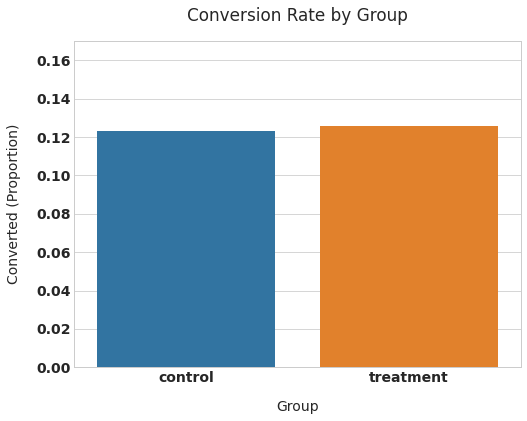

In [15]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion Rate by Group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (Proportion)', labelpad=15)

At first glance, it looks like the results are the same between the control and treatment groups.
<br/>Now let's see if the difference is statistically significant!

### Hypothesis Testing <a name="hyp_testing_AB"></a>

Now comes the moment of truth. Hypothesis testing will show confirm whether the new design had a meaningful impact. Since our sample size is large enough, we can use normal approximation for calculating our p-value (z-test). 

In [20]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.34
p-value: 0.732
ci 95% for control group: [0.114, 0.133]
ci 95% for treatment group: [0.116, 0.135]


In [29]:
# control_results.sum() #582
# treatment_results.count() #4720
# n_con, n_treat #4720, 4720

In [69]:
# data_barh_attacks = combined_data.sort_values(by='attack_type', ascending=False) #, inplace=True)
data_barh_attacks = combined_data['attack_type'].value_counts() #sort_values(by='attack_type', ascending=False) #, inplace=True)

In [70]:
# combined_data.groupby('attack_type').agg(
#             attack_mean = ('attack_type', 'mean'),
#             attack_count = ('attack_type', 'count'))

## Conclusion <a name="conclusion_AB"></a>

In [32]:
print(f'Since p-value={pval:.3f} is much greater than our threshold of α=0.05, \nwe cannot reject the Null hypothesis, Hₒ.')

Since p-value=0.732 is much greater than our threshold of α=0.05, 
we cannot reject the Null hypothesis, Hₒ.


That means that the new design did not perform siginificantly different. I guess we'll have to give the design another look. The silver lining is that the confidence interval of the treatment group was in line with the 13% conversion rate that we started with (so it wasn't necessarily worse).  So, the conversion rate of the new design is similar to the old design.